In [43]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.neural_network import *
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

import datetime

import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#Loading numpy
from numpy import load

Using device: cuda


### NN model for OCTMNIST

In [2]:
DATASET_PATH ='./OCTMNIST/octmnist.npz'

In [3]:
dataset = load(DATASET_PATH)
print(dataset.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
x_train, y_train = dataset['train_images'], dataset['train_labels']
x_val, y_val = dataset['val_images'], dataset['val_labels']
x_test, y_test = dataset['test_images'], dataset['test_labels']

print('x train shape = ', x_train.shape)
print('y train shape = ', y_train.shape)
print('x valid shape = ', x_val.shape)
print('y valid shape = ', y_val.shape)
print('x test shape = ', x_test.shape)
print('y test shape = ', y_test.shape)
num_class = len(np.unique(y_train))
print("num class = ", num_class)

x train shape =  (97477, 28, 28)
y train shape =  (97477, 1)
x valid shape =  (10832, 28, 28)
y valid shape =  (10832, 1)
x test shape =  (1000, 28, 28)
y test shape =  (1000, 1)
num class =  4


### Print sample images

(97477, 28, 28)


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


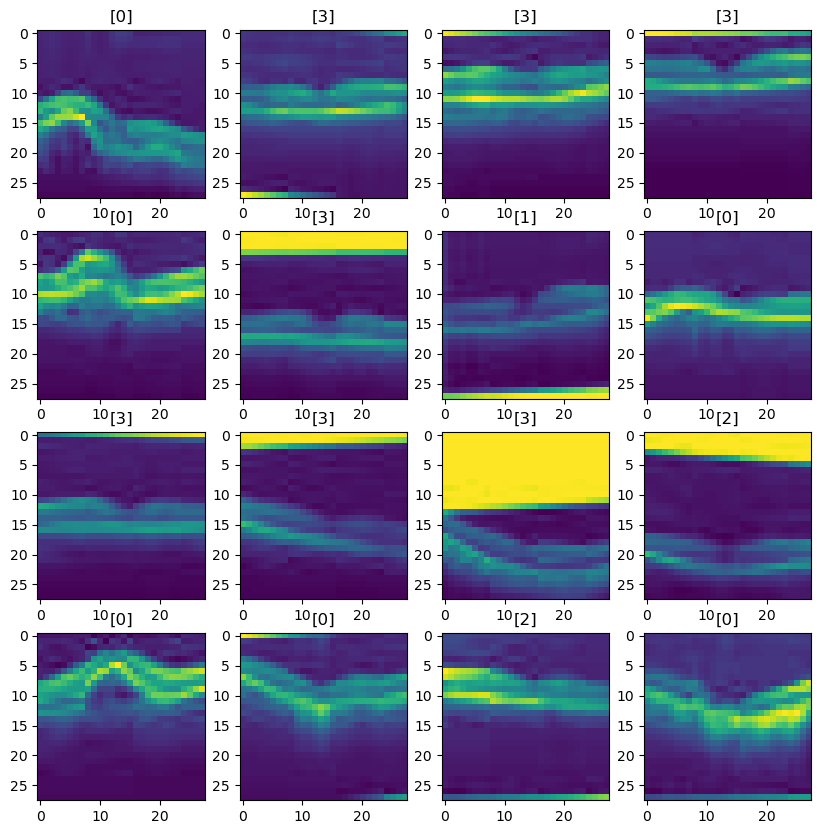

In [5]:
fig, axes = plt.subplots(4,4, figsize = (10,10))
i = 0
print(x_train.shape)
for r in range(4):
    for c in range(4):
        axes[r,c].imshow(x_train[i])
        axes[r,c].set_title(y_train[i])
        i += 1

### Building a CNN 

In [6]:
a = torch.rand(100,24,24).unsqueeze(1)
print(a.shape)

torch.Size([100, 1, 24, 24])


In [44]:
class OCTMNISTDataset(Dataset):
  def __init__(self, x_train, y_train, device):
    self.x = torch.tensor(x_train, device = device).type(torch.float).unsqueeze(1)
    self.y = torch.tensor(y_train, device = device).type(torch.long).squeeze(-1)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def get_dataloader(self, batch_size = 64, is_test = False):
    if is_test:
      batch_size = len(self.x)
    dataloader =  DataLoader(self, batch_size = batch_size, shuffle = True)
    return dataloader

train_dataset = OCTMNISTDataset(x_train, y_train, DEVICE)
train_dataloader = train_dataset.get_dataloader()
print('train_dataloader len =', len(train_dataloader))
val_dataset = OCTMNISTDataset(x_val, y_val, DEVICE)
val_dataloader = val_dataset.get_dataloader()
print('val_dataloader len =', len(val_dataloader))
test_dataset = OCTMNISTDataset(x_test, y_test, DEVICE)
test_dataloader = test_dataset.get_dataloader(is_test=True)
print('test_dataloader len =', len(test_dataloader))

train_dataloader len = 1524
val_dataloader len = 170
test_dataloader len = 1


In [19]:
image, label = next(iter(train_dataloader))
print('image shape ', image.shape)
print('label shape ', label.shape)

image shape  torch.Size([64, 1, 28, 28])
label shape  torch.Size([64])


In [75]:
model = nn.Sequential(
    nn.LazyConv2d(16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.2),
    nn.LazyConv2d(32,5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.LazyLinear(num_class),
)

model.to(DEVICE)
x,y = next(iter(train_dataloader))
print('image shape =', x.shape)
print('label shape = ', y.shape)
summary(model, input_size = x[0].shape)

y_pred = model(x)
# print('y pred  ', y_pred.shape)

optim = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

epochs = 25
history = []

best_score = 0
best_weights = None

def accuracy(model, test_dataloader):
  x,y = next(iter(test_dataloader))
  y = y.cpu().numpy()
  y_pred = model(x)
  y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis = 1)
  return accuracy_score(y, y_pred)

for e in range(epochs):
  print("EPOCH = ", e)
  running_loss = 0.0
  saved_checkpoint = False
  for x,y in tqdm(train_dataloader):
    # print(x.shape)
    # print(y.shape)
    y_pred = model(x)
    # print(y_pred.shape)
    loss = criterion(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    running_loss += loss.item()

  running_loss_val = 0.0

  for x,y in tqdm(val_dataloader):
    # print(x.shape)
    # print(y.shape)
    y_pred = model(x)
    # print(y_pred.shape)
    loss = criterion(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    running_loss_val += loss.item()

  #measure accuracy
  train_score = accuracy(model, train_dataloader)
  val_score = accuracy(model, val_dataloader)
  test_score = accuracy(model, test_dataloader)

  if best_score < val_score:
    torch.save({
      'epoch': e,
      'model_state_dict': model.state_dict(),
      'optim_state_dict': optim.state_dict(),
      'train_loss': running_loss,
      'val_loss': running_loss_val,
      'train_accuracy': train_score,
      'val_accuracy': val_score,
    }, 'checkpoint.torch')
    best_score = val_score
    saved_checkpoint = True


  print(f'e={e}, loss = {running_loss}, val accuracy = {val_score}, test accuracy = {test_score}' + ('(saved checkpoint}' if saved_checkpoint else ''))
  history.append({'train_loss': running_loss, 'val_loss': running_loss_val, 'val_accuracy':val_score, 'train_accuracy':train_score})

print(history)

torch.save(model, f'nn.{epochs}epoch.h5')

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


image shape = torch.Size([64, 1, 28, 28])
label shape =  torch.Size([64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
       BatchNorm2d-2           [-1, 16, 24, 24]              32
              ReLU-3           [-1, 16, 24, 24]               0
         MaxPool2d-4           [-1, 16, 12, 12]               0
           Dropout-5           [-1, 16, 12, 12]               0
            Conv2d-6             [-1, 32, 8, 8]          12,832
       BatchNorm2d-7             [-1, 32, 8, 8]              64
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
          Dropout-10             [-1, 32, 4, 4]               0
          Flatten-11                  [-1, 512]               0
           Linear-12                  [-1, 512]         262,656
             ReLU-13         

100%|██████████| 170/170 [00:00<00:00, 238.45it/s]


e=0, loss = 936.1716639697552, val accuracy = 0.84375, test accuracy = 0.64(saved checkpoint}
EPOCH =  1


100%|██████████| 170/170 [00:00<00:00, 203.46it/s]


e=1, loss = 708.3749935925007, val accuracy = 0.828125, test accuracy = 0.625
EPOCH =  2


100%|██████████| 170/170 [00:00<00:00, 236.71it/s]


e=2, loss = 642.2401354964823, val accuracy = 0.859375, test accuracy = 0.677(saved checkpoint}
EPOCH =  3


100%|██████████| 170/170 [00:00<00:00, 231.52it/s]


e=3, loss = 598.0886208415031, val accuracy = 0.890625, test accuracy = 0.706(saved checkpoint}
EPOCH =  4


100%|██████████| 170/170 [00:00<00:00, 236.04it/s]


e=4, loss = 567.0564777776599, val accuracy = 0.84375, test accuracy = 0.674
EPOCH =  5


100%|██████████| 170/170 [00:00<00:00, 237.89it/s]


e=5, loss = 544.5385599061847, val accuracy = 0.90625, test accuracy = 0.684(saved checkpoint}
EPOCH =  6


100%|██████████| 170/170 [00:00<00:00, 212.29it/s]


e=6, loss = 523.3841656148434, val accuracy = 0.921875, test accuracy = 0.67(saved checkpoint}
EPOCH =  7


100%|██████████| 170/170 [00:00<00:00, 233.02it/s]


e=7, loss = 507.17704098671675, val accuracy = 0.90625, test accuracy = 0.725
EPOCH =  8


100%|██████████| 170/170 [00:00<00:00, 235.35it/s]


e=8, loss = 491.5828364342451, val accuracy = 0.921875, test accuracy = 0.7
EPOCH =  9


100%|██████████| 170/170 [00:00<00:00, 230.97it/s]


e=9, loss = 481.51741076260805, val accuracy = 0.84375, test accuracy = 0.699
EPOCH =  10


100%|██████████| 170/170 [00:00<00:00, 232.14it/s]


e=10, loss = 470.02749171853065, val accuracy = 0.890625, test accuracy = 0.71
EPOCH =  11


100%|██████████| 170/170 [00:00<00:00, 214.56it/s]


e=11, loss = 455.5439889803529, val accuracy = 0.84375, test accuracy = 0.756
EPOCH =  12


100%|██████████| 170/170 [00:00<00:00, 228.20it/s]


e=12, loss = 447.9018840417266, val accuracy = 0.859375, test accuracy = 0.682
EPOCH =  13


100%|██████████| 170/170 [00:00<00:00, 228.93it/s]


e=13, loss = 436.84515522792935, val accuracy = 0.953125, test accuracy = 0.721(saved checkpoint}
EPOCH =  14


100%|██████████| 170/170 [00:00<00:00, 237.28it/s]


e=14, loss = 428.741052262485, val accuracy = 0.953125, test accuracy = 0.706
EPOCH =  15


100%|██████████| 170/170 [00:00<00:00, 227.72it/s]


e=15, loss = 422.5280222892761, val accuracy = 0.9375, test accuracy = 0.71
EPOCH =  16


100%|██████████| 170/170 [00:00<00:00, 222.60it/s]


e=16, loss = 415.2030562981963, val accuracy = 0.953125, test accuracy = 0.681
EPOCH =  17


100%|██████████| 170/170 [00:00<00:00, 227.30it/s]


e=17, loss = 405.20519568026066, val accuracy = 0.921875, test accuracy = 0.713
EPOCH =  18


100%|██████████| 170/170 [00:00<00:00, 238.59it/s]


e=18, loss = 398.3349062278867, val accuracy = 0.890625, test accuracy = 0.709
EPOCH =  19


100%|██████████| 170/170 [00:00<00:00, 235.44it/s]


e=19, loss = 390.4607198834419, val accuracy = 0.859375, test accuracy = 0.731
EPOCH =  20


100%|██████████| 170/170 [00:00<00:00, 217.66it/s]


e=20, loss = 384.08311804383993, val accuracy = 0.890625, test accuracy = 0.712
EPOCH =  21


100%|██████████| 170/170 [00:00<00:00, 232.79it/s]


e=21, loss = 375.65281442552805, val accuracy = 0.890625, test accuracy = 0.713
EPOCH =  22


100%|██████████| 170/170 [00:00<00:00, 223.51it/s]


e=22, loss = 371.4246005937457, val accuracy = 0.953125, test accuracy = 0.694
EPOCH =  23


100%|██████████| 170/170 [00:00<00:00, 221.94it/s]


e=23, loss = 366.273994371295, val accuracy = 0.953125, test accuracy = 0.69
EPOCH =  24


100%|██████████| 170/170 [00:00<00:00, 226.56it/s]

e=24, loss = 362.51834358274937, val accuracy = 0.9375, test accuracy = 0.704
[{'train_loss': 936.1716639697552, 'val_loss': 82.68052926659584, 'val_accuracy': 0.84375, 'train_accuracy': 0.78125}, {'train_loss': 708.3749935925007, 'val_loss': 72.4947781264782, 'val_accuracy': 0.828125, 'train_accuracy': 0.796875}, {'train_loss': 642.2401354964823, 'val_loss': 69.31786225736141, 'val_accuracy': 0.859375, 'train_accuracy': 0.859375}, {'train_loss': 598.0886208415031, 'val_loss': 63.97185914218426, 'val_accuracy': 0.890625, 'train_accuracy': 0.890625}, {'train_loss': 567.0564777776599, 'val_loss': 67.65559159219265, 'val_accuracy': 0.84375, 'train_accuracy': 0.828125}, {'train_loss': 544.5385599061847, 'val_loss': 58.60101805627346, 'val_accuracy': 0.90625, 'train_accuracy': 0.875}, {'train_loss': 523.3841656148434, 'val_loss': 57.85634446144104, 'val_accuracy': 0.921875, 'train_accuracy': 0.859375}, {'train_loss': 507.17704098671675, 'val_loss': 57.41158835589886, 'val_accuracy': 0.90625

In [76]:
print(history)
train_loss = []
val_loss = []
val_accuracy = []
train_accuracy = []

for data in history:
    train_loss.append(data['train_loss'])
    val_loss.append(data['val_loss'])
    train_accuracy.append(data['train_accuracy'])
    val_accuracy.append(data['val_accuracy'])

[{'train_loss': 936.1716639697552, 'val_loss': 82.68052926659584, 'val_accuracy': 0.84375, 'train_accuracy': 0.78125}, {'train_loss': 708.3749935925007, 'val_loss': 72.4947781264782, 'val_accuracy': 0.828125, 'train_accuracy': 0.796875}, {'train_loss': 642.2401354964823, 'val_loss': 69.31786225736141, 'val_accuracy': 0.859375, 'train_accuracy': 0.859375}, {'train_loss': 598.0886208415031, 'val_loss': 63.97185914218426, 'val_accuracy': 0.890625, 'train_accuracy': 0.890625}, {'train_loss': 567.0564777776599, 'val_loss': 67.65559159219265, 'val_accuracy': 0.84375, 'train_accuracy': 0.828125}, {'train_loss': 544.5385599061847, 'val_loss': 58.60101805627346, 'val_accuracy': 0.90625, 'train_accuracy': 0.875}, {'train_loss': 523.3841656148434, 'val_loss': 57.85634446144104, 'val_accuracy': 0.921875, 'train_accuracy': 0.859375}, {'train_loss': 507.17704098671675, 'val_loss': 57.41158835589886, 'val_accuracy': 0.90625, 'train_accuracy': 0.890625}, {'train_loss': 491.5828364342451, 'val_loss': 5

<Axes: >

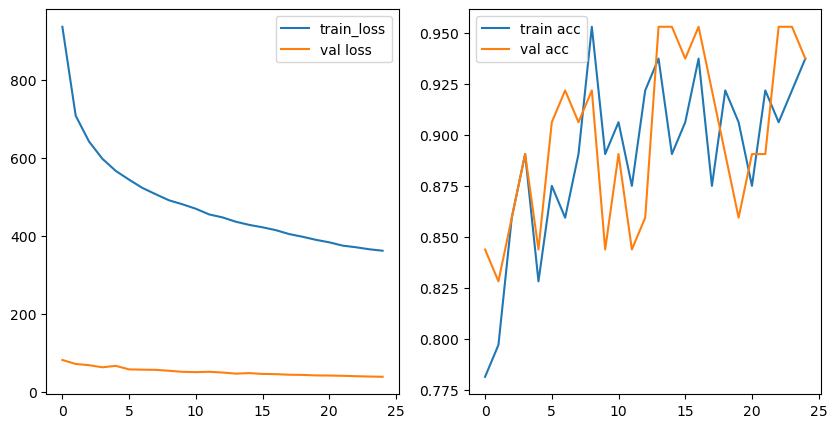

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(train_loss, ax = ax1, label = 'train_loss')
sns.lineplot(val_loss, ax = ax1, label = 'val loss')
sns.lineplot(train_accuracy, ax = ax2, label = 'train acc')
sns.lineplot(val_accuracy, ax = ax2, label = 'val acc')



In [78]:
#Load the best model for testing 
checkpoint = torch.load('checkpoint.torch')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [79]:
x_test, y_test = next(iter(test_dataloader))
y_pred = model(x_test)
y_pred = torch.argmax(y_pred, dim = 1).cpu().numpy()
y_test = y_test.cpu().numpy()
print(y_pred[:10])
print(y_test[:10])
test_score = accuracy(model, test_dataloader)
print(test_score)

[3 3 3 3 3 1 0 0 1 1]
[2 2 2 3 2 0 2 1 1 1]
0.711


[[235  54  97   4]
 [ 11 178   8   5]
 [  2   3  62   4]
 [  2  15  83 237]]


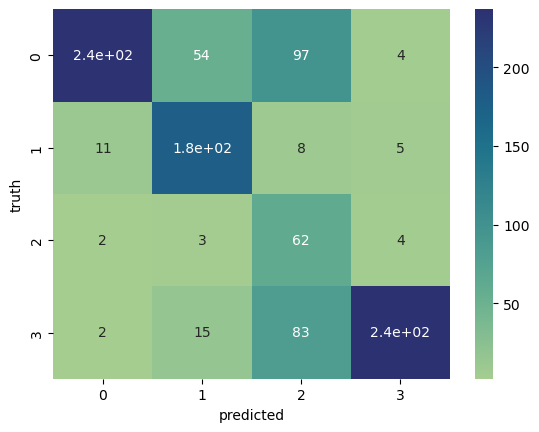

In [80]:
cm = confusion_matrix(y_pred, y_test)
print(cm)
sns.heatmap(cm, annot = True, cmap='crest')
plt.ylabel("truth")
plt.xlabel("predicted")
plt.show()